In [2]:
%load_ext autoreload
%autoreload 2
# this only works on startup!
from jax import config
config.update("jax_enable_x64", True)

import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = '1'
from encoding_information.gpu_utils import limit_gpu_memory_growth
limit_gpu_memory_growth()

from cleanplots import *
from tqdm import tqdm
from signal_utils_1D import *


2024-01-24 17:57:36.990479: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Show transition behavior with different SNR levels

In [18]:
from scipy.signal import resample
import jax.numpy as np

N_objects = 5000
noise_sigma = 1e-3
num_samples_list = [1, 4, 9, 16, 25, 36]
num_bootstrap_samples = 11
upsampling_factor = 16
max_epochs = 5000
confidence = 90
num_nyquist_samples = 16
noise_sigmas_list = 1 / num_nyquist_samples / np.array([1e0, 1e1, 1e2, 1e3, 1e4])




upsampled_signal_length = upsampling_factor*num_nyquist_samples
objects_fn_delta = lambda : np.array([generate_random_object('delta', num_deltas=1, object_size=upsampled_signal_length) for i in range(N_objects)])
objects_fn_white_noise = lambda : np.array([generate_random_object('white_noise', object_size=upsampled_signal_length) for i in range(N_objects)])


mi_by_snr_median = {}
mi_by_snr_hi = {}
mi_by_snr_lo = {}
for noise_sigma in noise_sigmas_list:
  noise_sigma = float(noise_sigma)
  print('noise sigma', noise_sigma)
  mutual_information = []
  mi_hi = []
  mi_lo = []

  objects_fn = lambda : np.array([generate_random_object('delta', num_deltas=8, object_size=upsampled_signal_length) for i in range(N_objects)])


  # Find an optimal PSF for this object
  initial_kernel, initial_params, optimized_params, objects, _, _ = optimize_PSF_and_estimate_mi(
      objects_fn, noise_sigma, num_nyquist_samples=num_nyquist_samples, upsampled_signal_length=upsampled_signal_length,
      max_epochs=max_epochs, )

  # compute the information with this psf when integrating over pixels of different sizes 
  for num_samples in tqdm(num_samples_list):


    runs = []
    for i in range(num_bootstrap_samples):

      # do the estimation
      scale_factor = 100000 # because these signals are 0-1 but pixel cnn is designed for photon counts
      test_objects = objects_fn()
      output_signals = conv_forward_model(optimized_params, test_objects,
                                                  integrate_output_signals=False, num_nyquist_samples=num_nyquist_samples, upsampled_signal_length=upsampled_signal_length)
      
      # interpolate to higher resolution before integrating
      resampled_signal_length = num_samples * upsampling_factor

      resampled_output_signals = resample(output_signals, resampled_signal_length, axis=-1)
      # normalize to sum to 1
      resampled_output_signals = resampled_output_signals / np.sum(resampled_output_signals, axis=-1, keepdims=True)
      pixelated_signal = integrate_pixels(resampled_output_signals, num_samples)

      # amount of noise to add to the pixel depends on its area
      relative_sampling_area = num_nyquist_samples / num_samples
      pixel_variance = noise_sigma**2 * relative_sampling_area

      noisy_pixelated_signals = pixelated_signal + jax.random.normal(jax.random.PRNGKey(onp.random.randint(10000)), pixelated_signal.shape) * np.sqrt(pixel_variance)

      fake_images = noisy_pixelated_signals.reshape(-1, int(np.sqrt(num_samples)), int(np.sqrt(num_samples))) * scale_factor
      mi_estimate = estimate_mutual_information(fake_images, gaussian_noise_sigma=float(np.sqrt(pixel_variance) * scale_factor), verbose=False, entropy_model='pixelcnn')                                                      
      print(mi_estimate)
      runs.append(mi_estimate)
    runs = np.array(runs)
    mutual_information.append(np.median(runs))
    mi_lo.append(np.percentile(np.array(runs), 100-confidence))
    mi_hi.append(np.percentile(np.array(runs), confidence))
  mi_by_snr_median[noise_sigma] = mutual_information
  mi_by_snr_hi[noise_sigma] = mi_hi
  mi_by_snr_lo[noise_sigma] = mi_lo

noise sigma 0.0625
initial loss -0.019143756647452624
computing optimized mi


/home/hpinkard_waller/GitRepos/EncodingInformation/encoding_information/information_estimation.py:226: UserWarning: 21.50% of pixels are negative.
  warnings.warn(f"{np.sum(clean_images_if_available < 0) / clean_images_if_available.size:.2%} of pixels are negative.")
  0%|          | 0/6 [00:00<?, ?it/s]

-0.07177486492543338
-0.028415974851108958


/home/hpinkard_waller/GitRepos/EncodingInformation/encoding_information/information_estimation.py:226: UserWarning: 0.02% of pixels are negative.
  warnings.warn(f"{np.sum(clean_images_if_available < 0) / clean_images_if_available.size:.2%} of pixels are negative.")


-0.0831573646901375
0.06044402119668701
0.027715034806891074
0.02036793596203189
-0.008258232308780884
-0.04623750506411664
0.07784041029676182
0.04237483596643688
-0.012197322944142653


 17%|█▋        | 1/6 [17:41<1:28:28, 1061.71s/it]/home/hpinkard_waller/GitRepos/EncodingInformation/encoding_information/information_estimation.py:226: UserWarning: 7.76% of pixels are negative.
  warnings.warn(f"{np.sum(clean_images_if_available < 0) / clean_images_if_available.size:.2%} of pixels are negative.")


0.4610555898544541


/home/hpinkard_waller/GitRepos/EncodingInformation/encoding_information/information_estimation.py:226: UserWarning: 7.49% of pixels are negative.
  warnings.warn(f"{np.sum(clean_images_if_available < 0) / clean_images_if_available.size:.2%} of pixels are negative.")


0.47621895621572624


/home/hpinkard_waller/GitRepos/EncodingInformation/encoding_information/information_estimation.py:226: UserWarning: 7.50% of pixels are negative.
  warnings.warn(f"{np.sum(clean_images_if_available < 0) / clean_images_if_available.size:.2%} of pixels are negative.")


0.4516983577863104


/home/hpinkard_waller/GitRepos/EncodingInformation/encoding_information/information_estimation.py:226: UserWarning: 7.53% of pixels are negative.
  warnings.warn(f"{np.sum(clean_images_if_available < 0) / clean_images_if_available.size:.2%} of pixels are negative.")


0.4932727558752823


/home/hpinkard_waller/GitRepos/EncodingInformation/encoding_information/information_estimation.py:226: UserWarning: 7.74% of pixels are negative.
  warnings.warn(f"{np.sum(clean_images_if_available < 0) / clean_images_if_available.size:.2%} of pixels are negative.")


0.5195819738736713


/home/hpinkard_waller/GitRepos/EncodingInformation/encoding_information/information_estimation.py:226: UserWarning: 7.63% of pixels are negative.
  warnings.warn(f"{np.sum(clean_images_if_available < 0) / clean_images_if_available.size:.2%} of pixels are negative.")


0.5178470128917674


/home/hpinkard_waller/GitRepos/EncodingInformation/encoding_information/information_estimation.py:226: UserWarning: 7.67% of pixels are negative.
  warnings.warn(f"{np.sum(clean_images_if_available < 0) / clean_images_if_available.size:.2%} of pixels are negative.")


0.44788722224319055


/home/hpinkard_waller/GitRepos/EncodingInformation/encoding_information/information_estimation.py:226: UserWarning: 7.56% of pixels are negative.
  warnings.warn(f"{np.sum(clean_images_if_available < 0) / clean_images_if_available.size:.2%} of pixels are negative.")


0.4414812124638527


/home/hpinkard_waller/GitRepos/EncodingInformation/encoding_information/information_estimation.py:226: UserWarning: 7.70% of pixels are negative.
  warnings.warn(f"{np.sum(clean_images_if_available < 0) / clean_images_if_available.size:.2%} of pixels are negative.")


0.48036992947695095


/home/hpinkard_waller/GitRepos/EncodingInformation/encoding_information/information_estimation.py:226: UserWarning: 7.51% of pixels are negative.
  warnings.warn(f"{np.sum(clean_images_if_available < 0) / clean_images_if_available.size:.2%} of pixels are negative.")


0.4453515100388693


/home/hpinkard_waller/GitRepos/EncodingInformation/encoding_information/information_estimation.py:226: UserWarning: 7.66% of pixels are negative.
  warnings.warn(f"{np.sum(clean_images_if_available < 0) / clean_images_if_available.size:.2%} of pixels are negative.")
 33%|███▎      | 2/6 [41:18<1:24:42, 1270.68s/it]

0.4649465253475743


/home/hpinkard_waller/GitRepos/EncodingInformation/encoding_information/information_estimation.py:226: UserWarning: 16.18% of pixels are negative.
  warnings.warn(f"{np.sum(clean_images_if_available < 0) / clean_images_if_available.size:.2%} of pixels are negative.")


0.40607615015992604


/home/hpinkard_waller/GitRepos/EncodingInformation/encoding_information/information_estimation.py:226: UserWarning: 16.42% of pixels are negative.
  warnings.warn(f"{np.sum(clean_images_if_available < 0) / clean_images_if_available.size:.2%} of pixels are negative.")


0.4213220681936123


/home/hpinkard_waller/GitRepos/EncodingInformation/encoding_information/information_estimation.py:226: UserWarning: 16.13% of pixels are negative.
  warnings.warn(f"{np.sum(clean_images_if_available < 0) / clean_images_if_available.size:.2%} of pixels are negative.")


0.4092984171064916


/home/hpinkard_waller/GitRepos/EncodingInformation/encoding_information/information_estimation.py:226: UserWarning: 16.43% of pixels are negative.
  warnings.warn(f"{np.sum(clean_images_if_available < 0) / clean_images_if_available.size:.2%} of pixels are negative.")


0.42270205698413543


/home/hpinkard_waller/GitRepos/EncodingInformation/encoding_information/information_estimation.py:226: UserWarning: 16.30% of pixels are negative.
  warnings.warn(f"{np.sum(clean_images_if_available < 0) / clean_images_if_available.size:.2%} of pixels are negative.")


0.45886794466877373


/home/hpinkard_waller/GitRepos/EncodingInformation/encoding_information/information_estimation.py:226: UserWarning: 16.40% of pixels are negative.
  warnings.warn(f"{np.sum(clean_images_if_available < 0) / clean_images_if_available.size:.2%} of pixels are negative.")


0.4026571350607734


/home/hpinkard_waller/GitRepos/EncodingInformation/encoding_information/information_estimation.py:226: UserWarning: 16.52% of pixels are negative.
  warnings.warn(f"{np.sum(clean_images_if_available < 0) / clean_images_if_available.size:.2%} of pixels are negative.")


0.42117760276688754
0.4466805660980317


/home/hpinkard_waller/GitRepos/EncodingInformation/encoding_information/information_estimation.py:226: UserWarning: 16.51% of pixels are negative.
  warnings.warn(f"{np.sum(clean_images_if_available < 0) / clean_images_if_available.size:.2%} of pixels are negative.")


0.44788444465407135


/home/hpinkard_waller/GitRepos/EncodingInformation/encoding_information/information_estimation.py:226: UserWarning: 16.29% of pixels are negative.
  warnings.warn(f"{np.sum(clean_images_if_available < 0) / clean_images_if_available.size:.2%} of pixels are negative.")


0.4322711716781421


/home/hpinkard_waller/GitRepos/EncodingInformation/encoding_information/information_estimation.py:226: UserWarning: 16.08% of pixels are negative.
  warnings.warn(f"{np.sum(clean_images_if_available < 0) / clean_images_if_available.size:.2%} of pixels are negative.")
 50%|█████     | 3/6 [1:08:36<1:11:55, 1438.42s/it]

0.44048093549972916


/home/hpinkard_waller/GitRepos/EncodingInformation/encoding_information/information_estimation.py:226: UserWarning: 21.69% of pixels are negative.
  warnings.warn(f"{np.sum(clean_images_if_available < 0) / clean_images_if_available.size:.2%} of pixels are negative.")


0.30107526148222397


/home/hpinkard_waller/GitRepos/EncodingInformation/encoding_information/information_estimation.py:226: UserWarning: 21.57% of pixels are negative.
  warnings.warn(f"{np.sum(clean_images_if_available < 0) / clean_images_if_available.size:.2%} of pixels are negative.")


0.29026374411838435


/home/hpinkard_waller/GitRepos/EncodingInformation/encoding_information/information_estimation.py:226: UserWarning: 21.60% of pixels are negative.
  warnings.warn(f"{np.sum(clean_images_if_available < 0) / clean_images_if_available.size:.2%} of pixels are negative.")


0.30792017098656377


/home/hpinkard_waller/GitRepos/EncodingInformation/encoding_information/information_estimation.py:226: UserWarning: 21.30% of pixels are negative.
  warnings.warn(f"{np.sum(clean_images_if_available < 0) / clean_images_if_available.size:.2%} of pixels are negative.")


0.28450026152266994


/home/hpinkard_waller/GitRepos/EncodingInformation/encoding_information/information_estimation.py:226: UserWarning: 21.77% of pixels are negative.
  warnings.warn(f"{np.sum(clean_images_if_available < 0) / clean_images_if_available.size:.2%} of pixels are negative.")


0.31418033947796997
0.2840558583528404


/home/hpinkard_waller/GitRepos/EncodingInformation/encoding_information/information_estimation.py:226: UserWarning: 21.84% of pixels are negative.
  warnings.warn(f"{np.sum(clean_images_if_available < 0) / clean_images_if_available.size:.2%} of pixels are negative.")


0.2955401718468553


/home/hpinkard_waller/GitRepos/EncodingInformation/encoding_information/information_estimation.py:226: UserWarning: 21.38% of pixels are negative.
  warnings.warn(f"{np.sum(clean_images_if_available < 0) / clean_images_if_available.size:.2%} of pixels are negative.")


0.30006125177273685


/home/hpinkard_waller/GitRepos/EncodingInformation/encoding_information/information_estimation.py:226: UserWarning: 21.47% of pixels are negative.
  warnings.warn(f"{np.sum(clean_images_if_available < 0) / clean_images_if_available.size:.2%} of pixels are negative.")


0.2915818191545969


/home/hpinkard_waller/GitRepos/EncodingInformation/encoding_information/information_estimation.py:226: UserWarning: 21.65% of pixels are negative.
  warnings.warn(f"{np.sum(clean_images_if_available < 0) / clean_images_if_available.size:.2%} of pixels are negative.")


0.30035155848739326


/home/hpinkard_waller/GitRepos/EncodingInformation/encoding_information/information_estimation.py:226: UserWarning: 21.52% of pixels are negative.
  warnings.warn(f"{np.sum(clean_images_if_available < 0) / clean_images_if_available.size:.2%} of pixels are negative.")
 67%|██████▋   | 4/6 [1:33:12<48:25, 1452.98s/it]  

0.29348463520374307


/home/hpinkard_waller/GitRepos/EncodingInformation/encoding_information/information_estimation.py:226: UserWarning: 25.44% of pixels are negative.
  warnings.warn(f"{np.sum(clean_images_if_available < 0) / clean_images_if_available.size:.2%} of pixels are negative.")


0.20601834867123986


/home/hpinkard_waller/GitRepos/EncodingInformation/encoding_information/information_estimation.py:226: UserWarning: 25.40% of pixels are negative.
  warnings.warn(f"{np.sum(clean_images_if_available < 0) / clean_images_if_available.size:.2%} of pixels are negative.")


0.2063719450014138


/home/hpinkard_waller/GitRepos/EncodingInformation/encoding_information/information_estimation.py:226: UserWarning: 25.20% of pixels are negative.
  warnings.warn(f"{np.sum(clean_images_if_available < 0) / clean_images_if_available.size:.2%} of pixels are negative.")


/tmp/ipykernel_1873971/3359696138.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  base_colormap = plt.cm.get_cmap('inferno')


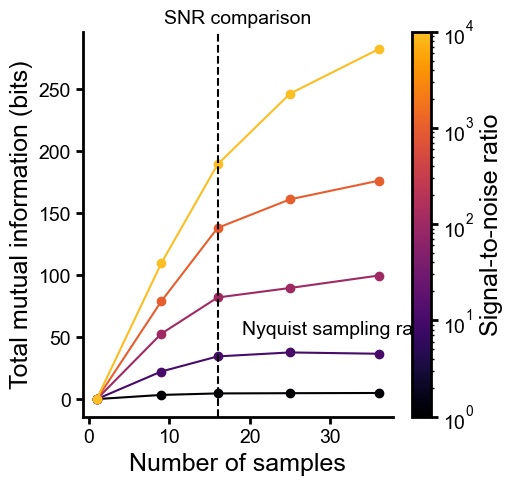

In [17]:
snrs = (1 / num_nyquist_samples) / np.array(noise_sigmas_list)

fig, ax = plt.subplots(1, 1, figsize=(5, 5))

# Define the start and end points--used so that high values aren't too light against white background
start, end = 0, 0.85
base_colormap = plt.cm.get_cmap('inferno')

from matplotlib.colors import LinearSegmentedColormap
# Create a new colormap from the portion of the original colormap
colormap = LinearSegmentedColormap.from_list(
    'trunc({n},{a:.2f},{b:.2f})'.format(n=base_colormap.name, a=start, b=end),
    base_colormap(np.linspace(start, end, 256))
)

colors = colormap(np.linspace(0, 1, len(noise_sigmas_list)))

for i, ((noise_sigma, mutual_information), snr) in enumerate(zip(mi_by_snr_median.items(), snrs)):

    total_mi = np.array(mutual_information) * np.array(num_samples_list)
    mi_lo = np.array(mi_by_snr_lo[noise_sigma]) * np.array(num_samples_list)
    mi_hi = np.array(mi_by_snr_hi[noise_sigma]) * np.array(num_samples_list)

    ax.plot(num_samples_list, total_mi,  'o-', color=colors[i], label=snr)
    ax.fill_between(num_samples_list, mi_lo, mi_hi, color=colors[i], alpha=0.2)
    
    ax.set_xlabel('Number of samples')
    ax.set_ylabel('Total mutual information (bits)')

    # ax.set(ylim=(0, max(1.1 * np.max(total_mi), ax.get_ylim()[1])))

# plot a dashed line at the number of nyquist samples
ax.axvline(num_nyquist_samples, linestyle='--', color='k')
ax.text(num_nyquist_samples + 3, 0.2 * np.max(total_mi), 'Nyquist sampling rate', rotation=0, va='center')
clear_spines(ax)
# ax.legend()
ax.set(title='SNR comparison')


from matplotlib.colors import LogNorm
# Create a scalar mappable object with the colormap and the snrs range
norm = LogNorm(vmin=np.min(snrs), vmax=np.max(snrs))
sm = plt.cm.ScalarMappable(cmap=colormap, norm=norm)
sm.set_array([])

# Add the colorbar to the figure
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label('Signal-to-noise ratio')
fig.savefig('/home/hpinkard_waller/figures/1d_signals/' + 'sampling_density_snr' + '.pdf', transparent=True, dpi=600)